In [1]:
from lib2to3.fixes.fix_input import context

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings

embedding_function = UpstageEmbeddings(model='solar-embedding-1-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:

from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_upstage import ChatUpstage

llm = ChatUpstage(model='solar-pro2')

In [10]:
from langchain import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatUpstage(model='solar-pro2')

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    # state에서 컨텍스트와 쿼리를 추출합니다
    context = state['context']
    query = state['query']

    # 작업 체인을 생성합니다: 먼저 프롬프트를 검색하고, 그 다음 응답을 생성합니다
    rag_chain = generate_prompt | generate_llm

    # 쿼리와 컨텍스트로 체인을 호출하여 응답을 얻습니다
    response = rag_chain.invoke({'question': query, 'context': context})

    # 생성된 답변을 반환합니다
    return {'answer': response.content}

In [8]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return 'relevant'

    return 'irrelevant'

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}


랭체인에서 제공하는 프롬프트가 정상적으로 동작하지 않을 수 있음

- generate 체인을 수정해서 답변이 짧게 나오도록 할 수 있다
- hallucination 프롬프트를 직접 작성할 수 있다.

In [11]:
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

# 할루시네이션 평가는 온도를 0으로 설정하여 일관된 대답을 하도록 합니다
hallucination_llm = ChatUpstage(model='solar-pro2', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})

    return response


In [13]:
query = '연봉 5천만원인 거주자의 소득세는 얼마인가요?'
context = retriever.invoke(query)
generate_state = {'query': query, 'context': context}
answer = generate(generate_state)
print(f"answer: {answer}")

hallucination_state = {'answer': answer, 'context': context}

check_hallucination(hallucination_state)

answer: {'answer': '주어진 연봉 5천만원에 대한 소득세를 정확히 계산하기에는 공제 항목과 과세표준에 대한 정보가 충분하지 않습니다. 다만, 종합소득세 과세표준이 5천만원일 경우 세율은 24%로, 약 1,200만원(624만원 + (5,000만원 - 1,400만원) × 24%) 정도가 될 수 있습니다. 정확한 금액은 근로소득공제 등 추가 공제를 적용해야 합니다.'}


'not hallucinated\n\n**Reasoning:**  \nThe student\'s answer is grounded in the provided documents, specifically referencing:  \n1. **제55조(세율)**에서 명시된 종합소득 과세표준 구간별 세율 (8,800만원 이하 구간에서 24% 적용).  \n2. 계산 예시인 *"624만원 + (5,000만원 - 1,400만원) × 24%"*는 문서의 세율 표와 일치합니다.  \n3. 추가적으로 **"근로소득공제 등"**을 언급한 부분은 **제48조(근로소득공제)**에 근거한 내용입니다.  \n\n학생은 문서 내 세율 및 공제 항목을 정확히 인용하며, 계산 과정을 제시했기 때문에 **"not hallucinated"**로 판단됩니다. 다만, 연봉 5천만원에 대한 총세액 계산을 완료하려면 근로소득공제, 의료비 공제 등 추가 정보가 필요하다는 점은 문서의 맥락과 일치합니다.'

In [14]:
from langchain import hub

# LangChain 허브에서 유용성 프롬프트를 가져옵니다
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> str:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다.

    Args:
        state (AgentState): 사용자의 질문과 생성된 답변을 포함한 에이전트의 현재 state.

    Returns:
        str: 답변이 유용하다고 판단되면 'helpful', 그렇지 않으면 'unhelpful'을 반환합니다.
    """
    # state에서 질문과 답변을 추출합니다
    query = state['query']
    answer = state['answer']

    # 답변의 유용성을 평가하기 위한 체인을 생성합니다
    helpfulness_chain = helpfulness_prompt | llm

    # 질문과 답변으로 체인을 호출합니다
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})

    # 점수가 1이면 'helpful'을 반환하고, 그렇지 않으면 'unhelpful'을 반환합니다
    if response['Score'] == 1:
        return 'helpful'

    return 'unhelpful'

def check_helpfulness(state: AgentState) -> AgentState:
    """
    유용성을 확인하는 자리 표시자 함수입니다.
    graph에서 conditional_edge를 연속으로 사용하지 않고 node를 추가해
    가독성을 높이기 위해 사용합니다

    Args:
        state (AgentState): 에이전트의 현재 state.

    Returns:
        AgentState: 변경되지 않은 state를 반환합니다.
    """
    # 이 함수는 현재 아무 작업도 수행하지 않으며 state를 그대로 반환합니다
    return state

In [15]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [16]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [17]:
graph = graph_builder.compile()


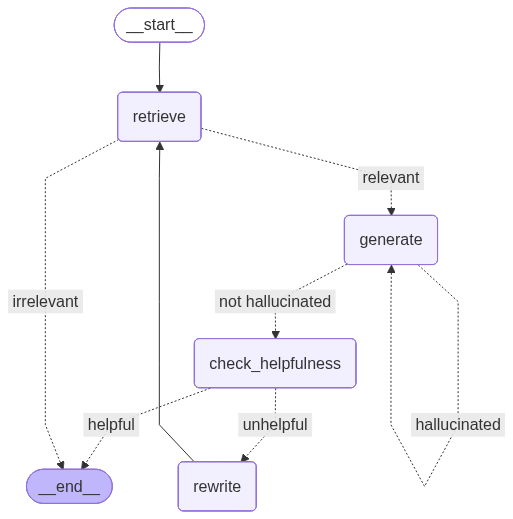

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
initial_state = {'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(id='32004e44-1451-43d3-8b07-a0be10a6c049', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12